# Benchmarks

This notebook will calculate benchmarks/baselines used in the thesis.

The following benchmarks are implemented in this notebook:

1. Simple heuristics
    - Predict the previous value
    - Predict the mean of the training data
    - Predict the moving average of the sequence
2. Linear regression
    - Linear regression using least squares minimisation
    - Ridge regression
    - LASSO
    - Elastic Nets (ElNet)
3. Simpler Machine Learning
    - Random Forest (RF)
    - Gradient Boosting Machines (GBM)

In [12]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

from functions import MAE, RMSE, split_dataset

# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## Data Loading 

In [34]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_scaled_train.pkl")
df_valid = pd.read_pickle(path + "df_scaled_valid.pkl")
df_test = pd.read_pickle(path + "df_scaled_test.pkl")

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_valid.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 44) (17737, 44) (17737, 44)
(53210, 41) (53210, 3)


In [203]:
def evaluate_error(preds, targets, target_stdevs=stats.loc[:len(target_tags)-1,"Std"].values):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    
    maes = MAE(targets, preds, vector=True)
    maes_unstd = (maes * target_stdevs)
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([["FT", "TT", "PT"], maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Avg", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

In [204]:
def evaluate_linear_model(model, x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    """
    Prints the performance of a model on the validation and testing data. Returns dictionaries of the validation
    and testing error. 
    
    :param model: The fitted model that can use the .predict() function
    :param x_valid: matrix of validation features. Default=x_valid.
    :param y_valid: matrix of validation targets. Default=y_valid.
    :param x_test: matrix of test features. Default=x_test.
    :param y_test: matrix of test targets. Default=y_test. 
    
    :return: dictionaries of validation and test errors as returned from evaluate_error()
    """
    
    print("\n       Validation data")
    preds = model.predict(x_valid)
    targets = y_valid
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds = model.predict(x_test)
    targets = y_test
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [205]:
def plot_linear_model(model, x_data=x_valid, y_data=y_valid, start_idx=0, n_obs=100, signal=1):
    """
    Plots a sample of the linear model.
    """
    preds = model.predict(x_data)
    targets = y_data
    
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
    for i in range(len(target_tags)):
        ax = axs[i]
        tag = target_tags[i]
        ax.plot(preds[start_idx:start_idx+n_obs,i], c="darkblue", lw=2, label="pred")
        ax.plot(targets[start_idx:start_idx+n_obs,i], c="darkred", lw=2, label="true")
        
        ax.set_title(target_tags[i])
        ax.legend(frameon=True) 
    
    fig.show()

### LINEAR REGRESSION

In [321]:
KA_tags = [tag for tag in feature_tags if "KA" in tag]
KA_tags = ['VAL_23-TT-92533:X.Value','VAL_23_TT_92532:Z.X.Value',
 'VAL_23_ZT_92543:Z.X.Value','VAL_23_FIC_92543_01:Z.X.Value',
 'VAL_23-FT-92512:X.Value']
KA_tags = df["Tag"].iloc[:30].values
KA_tags = ["VAL_23-TT-92533:X.Value", 
           "VAL_23_TT_92532:Z.X.Value",
           "VAL_23-KA-9101_APE:VALUE",
           "VAL_23-KA-9101_SPD:VALUE"
          ]
print(KA_tags)
delete_idxs = [np.where(feature_tags == tag)[0][0] for tag in KA_tags]
print(delete_idxs)
#---#
#delete_idxs = [np.where(feature_tags == "VAL_23-TIC-92504:Z.X.Value")[0][0]]
#---#

keep_idxs = np.delete(range(len(feature_tags)), delete_idxs)

selected_features = ["VAL_23-FT-92512:X.Value", "VAL_23-TT-92533:X.Value", "VAL_23-PT-92532:X.Value",
                    "VAL_23_ZT_92543:Z.X.Value", "VAL_23-KA-9101_ASP:VALUE"]
keep_idxs = [list(feature_tags).index(tag) for tag in selected_features]

xt = x_train[:,keep_idxs]
xtv = x_valid[:,keep_idxs]
xtt = x_test[:,keep_idxs]

lm.fit(xt, y_train)
preds = lm.predict(xtv)
targets = y_valid
vmae = round(MAE(targets, preds, vector=True)[1],4)
print(vmae)

val_linear, test_linear = evaluate_linear_model(lm, xtv, y_valid, xtt, y_test)

['VAL_23-TT-92533:X.Value', 'VAL_23_TT_92532:Z.X.Value', 'VAL_23-KA-9101_APE:VALUE', 'VAL_23-KA-9101_SPD:VALUE']
[31, 39, 3, 13]
0.3673

       Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.83666 |             2825.17442 |
|  1 | TT    |              0.36734 |                0.35864 |
|  2 | PT    |              0.61041 |                0.15107 |
|  3 | Avg   |              0.60480 |              941.89471 |
+----+-------+----------------------+------------------------+

       Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.83666 |             2825.17442 |
|  1 | TT    |              0.36734 |                0.35864 |


In [313]:
feature_tags

array(['VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value',
       'VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-KA-9101_APE:VALUE',
       'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE',
       'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE',
       'VAL_23-KA-9101_EPH:VALUE', 'VAL_23-KA-9101_EPR:VALUE',
       'VAL_23-KA-9101_ESP:VALUE', 'VAL_23-KA-9101_PHD:VALUE',
       'VAL_23-KA-9101_PRD:VALUE', 'VAL_23-KA-9101_SPD:VALUE',
       'VAL_23-LIC-92521:Z.X.Value', 'VAL_23-LIC-92521:Z.Y.Value',
       'VAL_23-LT-92523:Z.X1.Value', 'VAL_23-LT-92523:Z.X2.Value',
       'VAL_23-PDT-92502:X.Value', 'VAL_23-PDT-92522:X.Value',
       'VAL_23-PDT-92530:X.Value', 'VAL_23-PDT-92534:X.Value',
       'VAL_23-PT-92504:X.Value', 'VAL_23-PT-92512:X.Value',
       'VAL_23-PT-92521:X.Value', 'VAL_23-PT-92523:X.Value',
       'VAL_23-PT-92532:X.Value', 'VAL_23-PT-92535:X.Value',
       'VAL_23-TIC-92504:Z.X.Value', 'VAL_23-TT-92502:X.Value',
       'VAL_23-TT-92512:X.Value', 'VAL_23-TT-925

In [314]:
list(feature_tags).index("VAL_23_ZT_92543:Z.X.Value")

40

In [320]:
feature_tags
selected_features = ["VAL_23-FT-92512:X.Value", "VAL_23-TT-92533:X.Value", "VAL_23-PT-92532:X.Value",
                    "VAL_23_ZT_92543:Z.X.Value", "VAL_23-KA-9101_ASP:VALUE"]
idxs = [list(feature_tags).index(tag) for tag in selected_features]
print(idxs)

[0, 31, 26, 40, 6]


In [232]:
n_remove = 0
delete_tags = tag_imp["Tag"][:n_remove]
delete_idxs = delete_tags.index.tolist()

k=6
high_mae = 0
for i in range(len(feature_tags)-k):
    tags = [feature_tags[i+j] for j in range(k)]
    delete_idxs = [np.where(feature_tags == tag)[0][0] for tag in tags]
    
    
    #delete_idxs = [np.where(feature_tags == tag)[0][0]]
    keep_idxs = np.delete(range(len(feature_tags)), delete_idxs)
    xt = x_train[:,keep_idxs]
    xtv = x_valid[:,keep_idxs]
    
    lm.fit(xt, y_train)
    preds = lm.predict(xtv)
    targets = y_valid
    vmae = round(MAE(targets, preds, vector=True)[1],4)
    
    if vmae > high_mae:
        print("New highest MAE ({0}) when removing \n{1}\n".format(vmae, tags))
        high_mae=vmae

New highest MAE (0.1146) when removing 
['VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value', 'VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-KA-9101_APE:VALUE', 'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE']

New highest MAE (0.1174) when removing 
['VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-KA-9101_APE:VALUE', 'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE', 'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE']

New highest MAE (0.1195) when removing 
['VAL_23-KA-9101_APE:VALUE', 'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE', 'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE', 'VAL_23-KA-9101_EPH:VALUE']

New highest MAE (0.1213) when removing 
['VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE', 'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE', 'VAL_23-KA-9101_EPH:VALUE', 'VAL_23-KA-9101_EPR:VALUE']

New highest MAE (0.1247) when removing 
['VAL_23-PT-92512:X.Value', 'VAL_23-PT-92521:X.Value', 'VAL_23-PT-92523:X.Value', 'VAL_23-PT-92532:X.Value', '


       Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.66156 |             2233.91348 |
|  1 | TT    |              0.11294 |                0.11027 |
|  2 | PT    |              0.48510 |                0.12005 |
|  3 | Avg   |              0.41987 |              744.71460 |
+----+-------+----------------------+------------------------+

       Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.66156 |             2233.91348 |
|  1 | TT    |              0.11294 |                0.11027 |
|  2 | PT    |              0.48510 |                0.12005 |
|  3 | Avg   |              0.41987 |              744.71460 |
+----+----

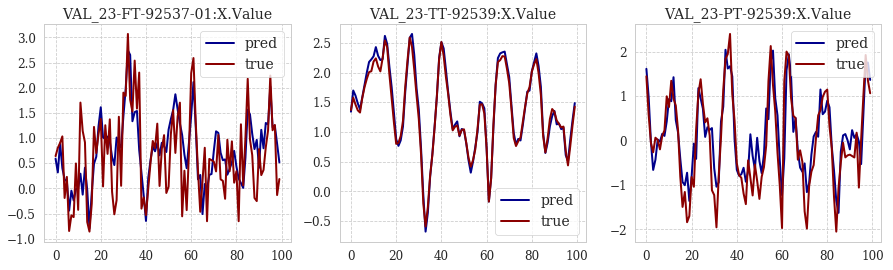

In [241]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)
plot_linear_model(lm)
val_linear, test_linear = evaluate_linear_model(lm)

In [244]:
lm.coef_[0,:]

array([-2.92724016e-01,  5.39736151e-02,  2.67448262e-01,  1.15621119e+00,
       -3.61555490e+00,  2.20568527e+00, -3.59858331e-01, -7.86599899e-01,
       -3.61344522e+00,  5.49872257e+00,  6.69363497e-01, -1.93875757e+00,
        1.91721531e+00,  1.89005415e+00, -1.40107564e-01,  2.93328534e-01,
        2.94809902e-03,  6.38861968e-02, -6.60440167e-02, -1.77158782e-02,
        7.00517802e-01, -2.27258582e-01,  2.92051066e-02,  4.60448777e-02,
        7.77660528e-01, -3.15016449e+00,  5.14008616e-01,  1.03630664e+00,
       -1.02052644e-01,  2.91130586e-01, -1.98247269e-01, -7.98198454e-01,
        4.26618929e-02,  2.18260893e+00,  4.37730670e-01, -7.42484832e-02,
        3.62106728e-01, -7.22210127e-01,  9.55887781e-01,  1.66778898e+00,
       -1.96982731e+00])

In [249]:
help(f_regression)

Help on function f_regression in module sklearn.feature_selection.univariate_selection:

f_regression(X, y, center=True)
    Univariate linear regression tests.
    
    Linear model for testing the individual effect of each of many regressors.
    This is a scoring function to be used in a feature selection procedure, not
    a free standing feature selection procedure.
    
    This is done in 2 steps:
    
    1. The correlation between each regressor and the target is computed,
       that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
       std(y)).
    2. It is converted to an F score then to a p-value.
    
    For more on usage see the :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}  shape = (n_samples, n_features)
        The set of regressors that will be tested sequentially.
    
    y : array of shape(n_samples).
        The data matrix
    
    center : True, bool,
        If true, 

{'score_func': <function sklearn.feature_selection.univariate_selection.f_regression(X, y, center=True)>,
 'k': 10}

In [298]:
from sklearn.feature_selection import f_regression, SelectKBest

kbest = SelectKBest(score_func=f_regression, k=10)
kbest.fit(x_train, y_train[:,1])
df = pd.DataFrame(list(zip(feature_tags, kbest.scores_)), columns=["Tag", "Imp"])
df = df.sort_values(by=["Imp"])

print(df["Tag"].iloc[:5].values)
df
#feature_tags[np.where(kbest.scores_ == max(kbest.scores_))[0][0]]

#pd.DataFrame(list(zip(feature_tags, f_imp)), columns=["Tag","Imp"])

['VAL_23-KA-9101-M01-62B:X.Value' 'VAL_23-TIC-92504:Z.X.Value'
 'VAL_23_KA_9101_M01_62C:Z.X.Value' 'VAL_23-KA-9101_EPE:VALUE'
 'VAL_23-PDT-92522:X.Value']


,Tag,Imp
2,VAL_23-KA-9101-M01-62B:X.Value,0.028660
28,VAL_23-TIC-92504:Z.X.Value,0.061612
37,VAL_23_KA_9101_M01_62C:Z.X.Value,0.276837
7,VAL_23-KA-9101_EPE:VALUE,2.523231
19,VAL_23-PDT-92522:X.Value,7.439119
8,VAL_23-KA-9101_EPH:VALUE,30.357287
9,VAL_23-KA-9101_EPR:VALUE,46.326894
6,VAL_23-KA-9101_ASP:VALUE,135.809671
24,VAL_23-PT-92521:X.Value,237.505030
21,VAL_23-PDT-92534:X.Value,353.907658


### RANDOM FOREST

In [43]:
from sklearn.ensemble import RandomForestRegressor
params_rf = {'n_estimators': 1000, 
             'max_depth': 5, 
             'min_samples_split': 2, 
             'max_features': 'auto', 
             'criterion': 'mse', 
             'random_state': 0, 
             'n_jobs': -1, 
             'oob_score': True,
             'verbose': 1
            }

rf = RandomForestRegressor(**params_rf)
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=0, verbose=1, warm_start=False)

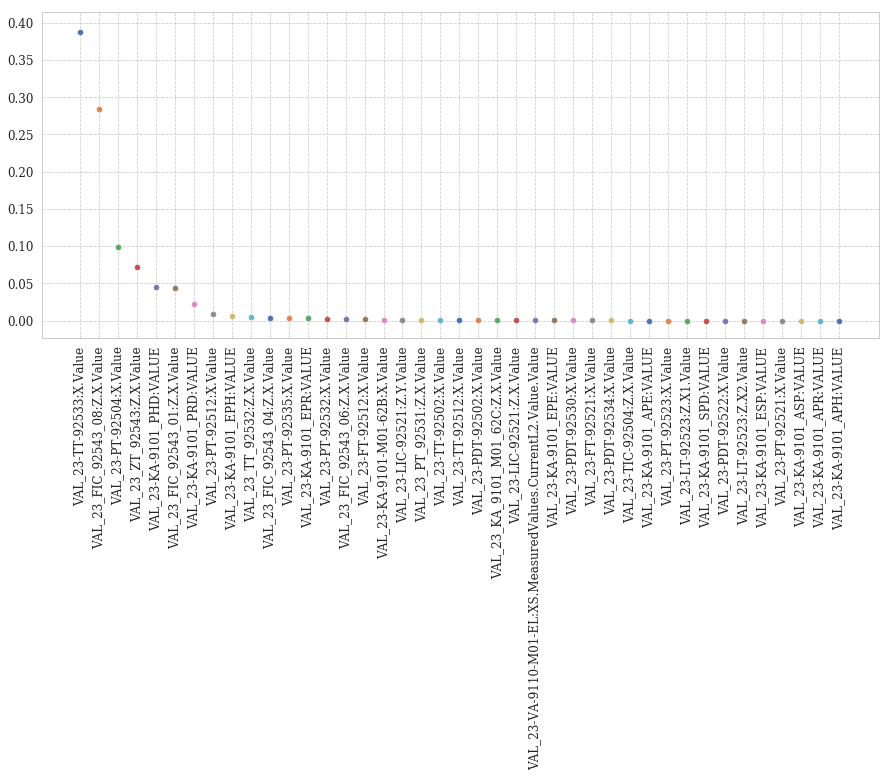

,Tag,Imp
31,VAL_23-TT-92533:X.Value,0.387568
36,VAL_23_FIC_92543_08:Z.X.Value,0.284619
22,VAL_23-PT-92504:X.Value,0.099193
40,VAL_23_ZT_92543:Z.X.Value,0.071848
11,VAL_23-KA-9101_PHD:VALUE,0.045687
33,VAL_23_FIC_92543_01:Z.X.Value,0.043198
12,VAL_23-KA-9101_PRD:VALUE,0.022532
23,VAL_23-PT-92512:X.Value,0.008543
8,VAL_23-KA-9101_EPH:VALUE,0.006487
39,VAL_23_TT_92532:Z.X.Value,0.005384


In [67]:
tag_imp = pd.DataFrame(list(zip(feature_tags, rf.feature_importances_)), columns=["Tag","Imp"])
tag_imp = tag_imp.sort_values(by=["Imp"], ascending=False)

plt.figure(figsize=(15,6))
for i in range(len(tag_imp)):
    plt.scatter(x=i, y=tag_imp.iloc[i]["Imp"])
    
plt.xticks(range(len(xticks)), tag_imp["Tag"], rotation=90)
plt.show()

tag_imp

In [71]:
tag_imp.index[tag_imp['Tag'] == "VAL_23-KA-9101_APE:VALUE"].tolist()

[3]